# 可视化网络结构
随着深度神经网络做的的发展，网络的结构越来越复杂，我们也很难确定每一层的输入结构，输出结构以及参数等信息，这样导致我们很难在短时间内完成debug。因此掌握一个可以用来可视化网络结构的工具是十分有必要的。类似的功能在另一个深度学习库Keras中可以调用一个叫做model.summary()的API来很方便地实现，调用后就会显示我们的模型参数，输入大小，输出大小，模型的整体参数等，但是在PyTorch中没有这样一种便利的工具帮助我们可视化我们的模型结构。

为了解决这个问题，人们开发了torchinfo工具包 ( torchinfo是由torchsummary和torchsummaryX重构出的库, torchsummary和torchsummaryX已经许久没更新了) 。本节介绍如何使用torchinfo来可视化网络结构。

## 使用print函数打印模型基础信息
在本节中，我们将使用ResNet18的结构进行展示。

In [2]:
import torchvision.models as models
model = models.resnet18()

通过上面的两步，我们就得到resnet18的模型结构。在学习torchinfo之前，让我们先看下直接print(model)的结果。

In [3]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
pip install torchinfo 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torchvision.models as models
from torchinfo import summary
resnet18 = models.resnet18() # 实例化模型
summary(model, (1, 3, 224, 224)) # 1：batch_size 3:图片的通道数 224: 图片的高宽

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

我们可以看到torchinfo提供了更加详细的信息，包括模块信息（每一层的类型、输出shape和参数量）、模型整体的参数量、模型大小、一次前向或者反向传播需要的内存大小等

注意：

但你使用的是colab或者jupyter notebook时，想要实现该方法，summary()一定是该单元（即notebook中的cell）的返回值，否则我们就需要使用print(summary(...))来可视化。

# CNN可视化
卷积神经网络（CNN）是深度学习中非常重要的模型结构，它广泛地用于图像处理，极大地提升了模型表现，推动了计算机视觉的发展和进步。但CNN是一个“黑盒模型”，人们并不知道CNN是如何获得较好表现的，由此带来了深度学习的可解释性问题。如果能理解CNN工作的方式，人们不仅能够解释所获得的结果，提升模型的鲁棒性，而且还能有针对性地改进CNN的结构以获得进一步的效果提升。

理解CNN的重要一步是可视化，包括可视化特征是如何提取的、提取到的特征的形式以及模型在输入数据上的关注点等。本节我们就从上述三个方面出发，介绍如何在PyTorch的框架下完成CNN模型的可视化。

 - 可视化CNN卷积核的方法
 - 可视化CNN特征图的方法
 - 可视化CNN显著图（class activation map）的方法

## CNN卷积核可视化
卷积核在CNN中负责提取特征，可视化卷积核能够帮助人们理解CNN各个层在提取什么样的特征，进而理解模型的工作原理。例如在Zeiler和Fergus 2013年的paper中就研究了CNN各个层的卷积核的不同，他们发现靠近输入的层提取的特征是相对简单的结构，而靠近输出的层提取的特征就和图中的实体形状相近了。

在PyTorch中可视化卷积核也非常方便，核心在于特定层的卷积核即特定层的模型权重，可视化卷积核就等价于可视化对应的权重矩阵。下面给出在PyTorch中可视化卷积核的实现方案，以torchvision自带的VGG11模型为例。

首先加载模型，并确定模型的层信息：

In [6]:
import torch
from torchvision.models import vgg11

model = vgg11(pretrained=True)
print(dict(model.features.named_children()))

{'0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '1': ReLU(inplace=True), '2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '3': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '4': ReLU(inplace=True), '5': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '6': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '7': ReLU(inplace=True), '8': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '9': ReLU(inplace=True), '10': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '11': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '12': ReLU(inplace=True), '13': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '14': ReLU(inplace=True), '15': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '16': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '17'

torch.Size([128, 64, 3, 3])


D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


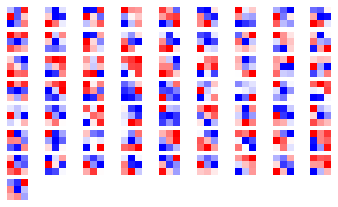

In [9]:
import matplotlib.pyplot as plt
conv1 = dict(model.features.named_children())['3']
kernel_set = conv1.weight.detach()
num = len(conv1.weight.detach())
print(kernel_set.shape)
for i in range(0,num):
    i_kernel = kernel_set[i]
    plt.figure(figsize=(20, 17))
    plt.close() #需加入这个代码，不然图片太多会报错

    if (len(i_kernel)) > 1:
        for idx, filer in enumerate(i_kernel):
            plt.subplot(9, 9, idx+1) 
            plt.axis('off')
            plt.imshow(filer[ :, :].detach(),cmap='bwr')

## CNN特征图可视化方法
与卷积核相对应，输入的原始图像经过每次卷积层得到的数据称为特征图，可视化卷积核是为了看模型提取哪些特征，可视化特征图则是为了看模型提取到的特征是什么样子的。

获取特征图的方法有很多种，可以从输入开始，逐层做前向传播，直到想要的特征图处将其返回。尽管这种方法可行，但是有些麻烦了。在PyTorch中，提供了一个专用的接口使得网络在前向传播过程中能够获取到特征图，这个接口的名称非常形象，叫做hook。可以想象这样的场景，数据通过网络向前传播，网络某一层我们预先设置了一个钩子，数据传播过后钩子上会留下数据在这一层的样子，读取钩子的信息就是这一层的特征图。具体实现如下：

In [10]:
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []

    def __call__(self,module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None
    

def plot_feature(model, idx, inputs):
    hh = Hook()
    model.features[idx].register_forward_hook(hh)
    
    # forward_model(model,False)
    model.eval()
    _ = model(inputs)
    print(hh.module_name)
    print((hh.features_in_hook[0][0].shape))
    print((hh.features_out_hook[0].shape))
    
    out1 = hh.features_out_hook[0]

    total_ft  = out1.shape[1]
    first_item = out1[0].cpu().clone()    

    plt.figure(figsize=(20, 17))
    

    for ftidx in range(total_ft):
        if ftidx > 99:
            break
        ft = first_item[ftidx]
        plt.subplot(10, 10, ftidx+1) 
        
        plt.axis('off')
        #plt.imshow(ft[ :, :].detach(),cmap='gray')
        plt.imshow(ft[ :, :].detach())

这里我们首先实现了一个hook类，之后在plot_feature函数中，将该hook类的对象注册到要进行可视化的网络的某层中。model在进行前向传播的时候会调用hook的\__call\__函数，我们也就是在那里存储了当前层的输入和输出。这里的features_out_hook 是一个list，每次前向传播一次，都是调用一次，也就是features_out_hook 长度会增加1。

## CNN class activation map可视化方法
class activation map （CAM）的作用是判断哪些变量对模型来说是重要的，在CNN可视化的场景下，即判断图像中哪些像素点对预测结果是重要的。除了确定重要的像素点，人们也会对重要区域的梯度感兴趣，因此在CAM的基础上也进一步改进得到了Grad-CAM（以及诸多变种）。

相比可视化卷积核与可视化特征图，CAM系列可视化更为直观，能够一目了然地确定重要区域，进而进行可解释性分析或模型优化改进。CAM系列操作的实现可以通过开源工具包pytorch-grad-cam来实现。

In [11]:
pip install grad-cam

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=0743c59325c699aefa10c02063a1513b00ec77dc33be93ad2c3d9734013e43e2
  Stored in directory: c:\users\baimu chu\appdata\local\pip\cache\wheels\30\ab\9c\53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


一个简单的例子

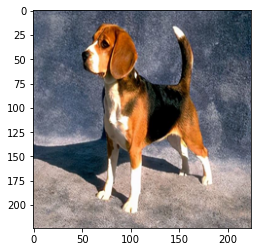

In [2]:
import torch
from torchvision.models import vgg11,resnet18,resnet101,resnext101_32x8d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

model = vgg11(pretrained=True)
img_path = './dog.jpeg'
# resize操作是为了和传入神经网络训练图片大小一致
img = Image.open(img_path).resize((224,224))
# 需要将原始图片转为np.float32格式并且在0-1之间 
rgb_img = np.float32(img)/255
plt.imshow(img)

<class 'numpy.ndarray'>


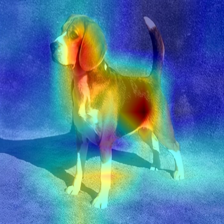

In [6]:
from pytorch_grad_cam import GradCAM,ScoreCAM,GradCAMPlusPlus,AblationCAM,XGradCAM,EigenCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

# preprocess_image作用：归一化图像，并转成tensor
img_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

target_layers = [model.features[-1]]
# 选取合适的类激活图，但是ScoreCAM和AblationCAM需要batch_size
cam = GradCAM(model=model,target_layers=target_layers)
targets = [ClassifierOutputTarget(200)]   
# 上方preds需要设定，比如ImageNet有1000类，这里可以设为200
targets=None
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)

## 使用FlashTorch快速实现CNN可视化
聪明的你可能要问了，已经202x年了，难道还要我们手把手去写各种CNN可视化的代码吗？答案当然是否定的。随着PyTorch社区的努力，目前已经有不少开源工具能够帮助我们快速实现CNN可视化。这里我们介绍其中的一个——FlashTorch。

（注：使用中发现该package对环境有要求，如果下方代码运行报错，请参考作者给出的配置或者Colab运行环境：https://github.com/MisaOgura/flashtorch/issues/39）

In [7]:
pip install flashtorch

  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26253 sha256=62d58bb7cab06f36db92749a47d85a8df029dd4a22e0795888169a231aff2634
  Stored in directory: c:\users\baimu chu\appdata\local\pip\cache\wheels\e8\bc\36\9ac3236719be1f1c6d1d758fc5e404410fe17027dd80d1d06d
Successfully built flashtorch
Note: you may need to restart the kernel to use updated packages.


In [1]:
#这里还是有些问题，我就先不管了，之后再调试一下
# Download example images
# !mkdir -p images
# !wget -nv \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/great_grey_owl.jpg \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/peacock.jpg   \
#    https://github.com/MisaOgura/flashtorch/raw/master/examples/images/toucan.jpg    \
#    -P /content/images

import matplotlib.pyplot as plt
import torchvision.models as models
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

model = models.alexnet(pretrained=True)
backprop = Backprop(model)

image = load_image('./great_grey_owl.jpg')
owl = apply_transforms(image)

target_class = 24
backprop.visualize(owl, target_class, guided=True, use_gpu=True)

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


RuntimeError: Output 0 of UnbindBackward is a view and is being modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

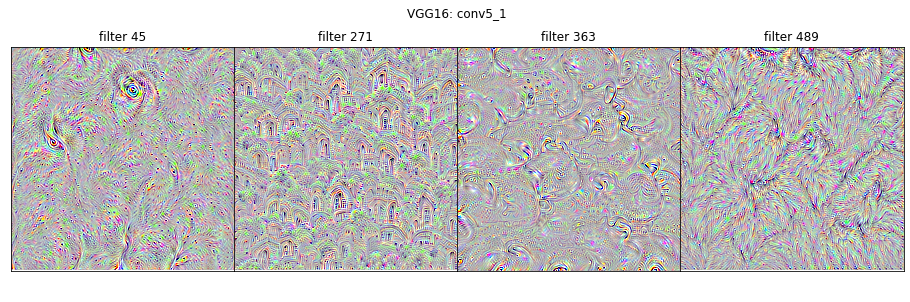

In [2]:
import torchvision.models as models
from flashtorch.activmax import GradientAscent

model = models.vgg16(pretrained=True)
g_ascent = GradientAscent(model.features)

# specify layer and filter info
conv5_1 = model.features[24]
conv5_1_filters = [45, 271, 363, 489]

g_ascent.visualize(conv5_1, conv5_1_filters, title="VGG16: conv5_1")

# 使用TensorBoard可视化训练过程
训练过程的可视化在深度学习模型训练中扮演着重要的角色。学习的过程是一个优化的过程，我们需要找到最优的点作为训练过程的输出产物。一般来说，我们会结合训练集的损失函数和验证集的损失函数，绘制两条损失函数的曲线来确定训练的终点，找到对应的模型用于测试。那么除了记录训练中每个epoch的loss值，能否实时观察损失函数曲线的变化，及时捕捉模型的变化呢？

此外，我们也希望可视化其他内容，如输入数据（尤其是图片）、模型结构、参数分布等，这些对于我们在debug中查找问题来源非常重要（比如输入数据和我们想象的是否一致）。

TensorBoard作为一款可视化工具能够满足上面提到的各种需求。TensorBoard由TensorFlow团队开发，最早和TensorFlow配合使用，后来广泛应用于各种深度学习框架的可视化中来。本节我们探索TensorBoard的强大功能，希望帮助读者“从入门到精通”。

 - 安装TensorBoard工具
 - 了解TensorBoard可视化的基本逻辑
 - 掌握利用TensorBoard实现训练过程可视化
 - 掌握利用TensorBoard完成其他内容的可视化

In [3]:
pip install tensorboardX

In [6]:
pip install tensorboard

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 2.0.0
    Uninstalling importlib-metadata-2.0.0:
      Successfully uninstalled importlib-metadata-2.0.0
Note: you may need to restart the kernel to use updated packages.


## TensorBoard可视化的基本逻辑
我们可以将TensorBoard看做一个记录员，它可以记录我们指定的数据，包括模型每一层的feature map，权重，以及训练loss等等。TensorBoard将记录下来的内容保存在一个用户指定的文件夹里，程序不断运行中TensorBoard会不断记录。记录下的内容可以通过网页的形式加以可视化。

## TensorBoard的配置与启动
在使用TensorBoard前，我们需要先指定一个文件夹供TensorBoard保存记录下来的数据。然后调用tensorboard中的SummaryWriter作为上述“记录员”

In [1]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('./runs')

上面的操作实例化SummaryWritter为变量writer，并指定writer的输出目录为当前目录下的"runs"目录。也就是说，之后tensorboard记录下来的内容都会保存在runs。

In [5]:
from torch.utils.tensorboard import SummaryWriter

## TensorBoard模型结构可视化

In [2]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


可视化模型的思路和7.1中介绍的方法一样，都是给定一个输入数据，前向传播后得到模型的结构，再通过TensorBoard进行可视化，使用add_graph：

In [6]:
import torch
writer.add_graph(model, input_to_model = torch.rand(1, 3, 224, 224))
writer.close()

在 prompt 中输入打开tensorboad

C:\Users\baimu chu>tensorboard --logdir=.\Datawhale-Pytorch_advanced\runs

然后在浏览器中打开http://localhost:6006/

## TensorBoard图像可视化
当我们做图像相关的任务时，可以方便地将所处理的图片在tensorboard中进行可视化展示。

 - 对于单张图片的显示使用add_image
 - 对于多张图片的显示使用add_images
 - 有时需要使用torchvision.utils.make_grid将多张图片拼成一张图片后，用writer.add_image显示

这里我们使用torchvision的CIFAR10数据集为例：

In [7]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose(
    [transforms.ToTensor()])
transform_test = transforms.Compose(
    [transforms.ToTensor()])

train_data = datasets.CIFAR10(".", train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(".", train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

images, labels = next(iter(train_loader))
 
# 仅查看一张图片
writer = SummaryWriter('./pytorch_tb')
writer.add_image('images[0]', images[0])
writer.close()
 
# 将多张图片拼接成一张图片，中间用黑色网格分割
# create grid of images
writer = SummaryWriter('./pytorch_tb')
img_grid = torchvision.utils.make_grid(images)
writer.add_image('image_grid', img_grid)
writer.close()
 
# 将多张图片直接写入
writer = SummaryWriter('./pytorch_tb')
writer.add_images("images",images,global_step = 0)
writer.close()

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to .\cifar-10-python.tar.gz


KeyboardInterrupt: 

## TensorBoard连续变量可视化
TensorBoard可以用来可视化连续变量（或时序变量）的变化过程，通过add_scalar实现：

In [ ]:
writer = SummaryWriter('./pytorch_tb')
for i in range(500):
    x = i
    y = x**2
    writer.add_scalar("x", x, i) #日志中记录x在第step i 的值
    writer.add_scalar("y", y, i) #日志中记录y在第step i 的值
writer.close()

如果想在同一张图中显示多个曲线，则需要分别建立存放子路径（使用SummaryWriter指定路径即可自动创建，但需要在tensorboard运行目录下），同时在add_scalar中修改曲线的标签使其一致即可：

In [ ]:
writer1 = SummaryWriter('./pytorch_tb/x')
writer2 = SummaryWriter('./pytorch_tb/y')
for i in range(500):
    x = i
    y = x*2
    writer1.add_scalar("same", x, i) #日志中记录x在第step i 的值
    writer2.add_scalar("same", y, i) #日志中记录y在第step i 的值
writer1.close()
writer2.close()

这里也可以用一个writer，但for循环中不断创建SummaryWriter不是一个好选项。此时左下角的Runs部分出现了勾选项，我们可以选择我们想要可视化的曲线。曲线名称对应存放子路径的名称（这里是x和y）。

这部分功能非常适合损失函数的可视化，可以帮助我们更加直观地了解模型的训练情况，从而确定最佳的checkpoint。左侧的Smoothing滑动按钮可以调整曲线的平滑度，当损失函数震荡较大时，将Smoothing调大有助于观察loss的整体变化趋势。

## TensorBoard参数分布可视化
当我们需要对参数（或向量）的变化，或者对其分布进行研究时，可以方便地用TensorBoard来进行可视化，通过add_histogram实现。下面给出一个例子：

In [ ]:
import torch
import numpy as np

# 创建正态分布的张量模拟参数矩阵
def norm(mean, std):
    t = std * torch.randn((100, 20)) + mean
    return t
 
writer = SummaryWriter('./pytorch_tb/')
for step, mean in enumerate(range(-10, 10, 1)):
    w = norm(mean, 1)
    writer.add_histogram("w", w, step)
    writer.flush()
writer.close()

## 总结
对于TensorBoard来说，它的功能是很强大的，可以记录的东西不只限于本节所介绍的范围。

主要的实现方案是构建一个SummaryWriter，然后通过add_XXX()函数来实现。

其实TensorBoard的逻辑还是很简单的，它的基本逻辑就是文件的读写逻辑，写入想要可视化的数据，然后TensorBoard自己会读出来